In [ ]:
import sys
sys.path.append('../../')

import pandas as pd
from python_src.figures_utils import get_all_expected, generate_experimental_df, get_relabund_files, fully_combined, generate_cb
from dataclasses import dataclass
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
@dataclass
class Pipeline:
    """
    This class will hold the parameters for each pipeline.
    Variables:
        root: str
            The root directory of the pipeline.
        inset: bool
            Whether or not to include an inset plot.
    """
    root: str
    inset: bool

    def __init__(self, root: str, inset: bool):
        self.root = root
        self.inset = inset

tourlousse = Pipeline("../../pipelines/tourlousse", False)
amos_hilo = Pipeline("../../pipelines/amos/hilo", False)
amos_mixed = Pipeline("../../pipelines/amos/mixed", False)

experiments = [tourlousse, amos_hilo, amos_mixed]

In [ ]:
def fix_x_labels(ax, df, rank):
    xticks = ax.get_xticklabels()
    # print(xticks)
    new_labels = []
    for x in xticks:
        # res = df.loc[int(x.get_text()), rank]
        res = df.loc[df["TAX_ID"] == int(x.get_text()), rank]
        # Get only the first row from the series.
        # This is necessary because if it is unique, it will return a string, but if it is not unique, it will return a series.
        if isinstance(res, pd.Series):
            res = res.iloc[0]
        new_labels.append(res)

    return new_labels

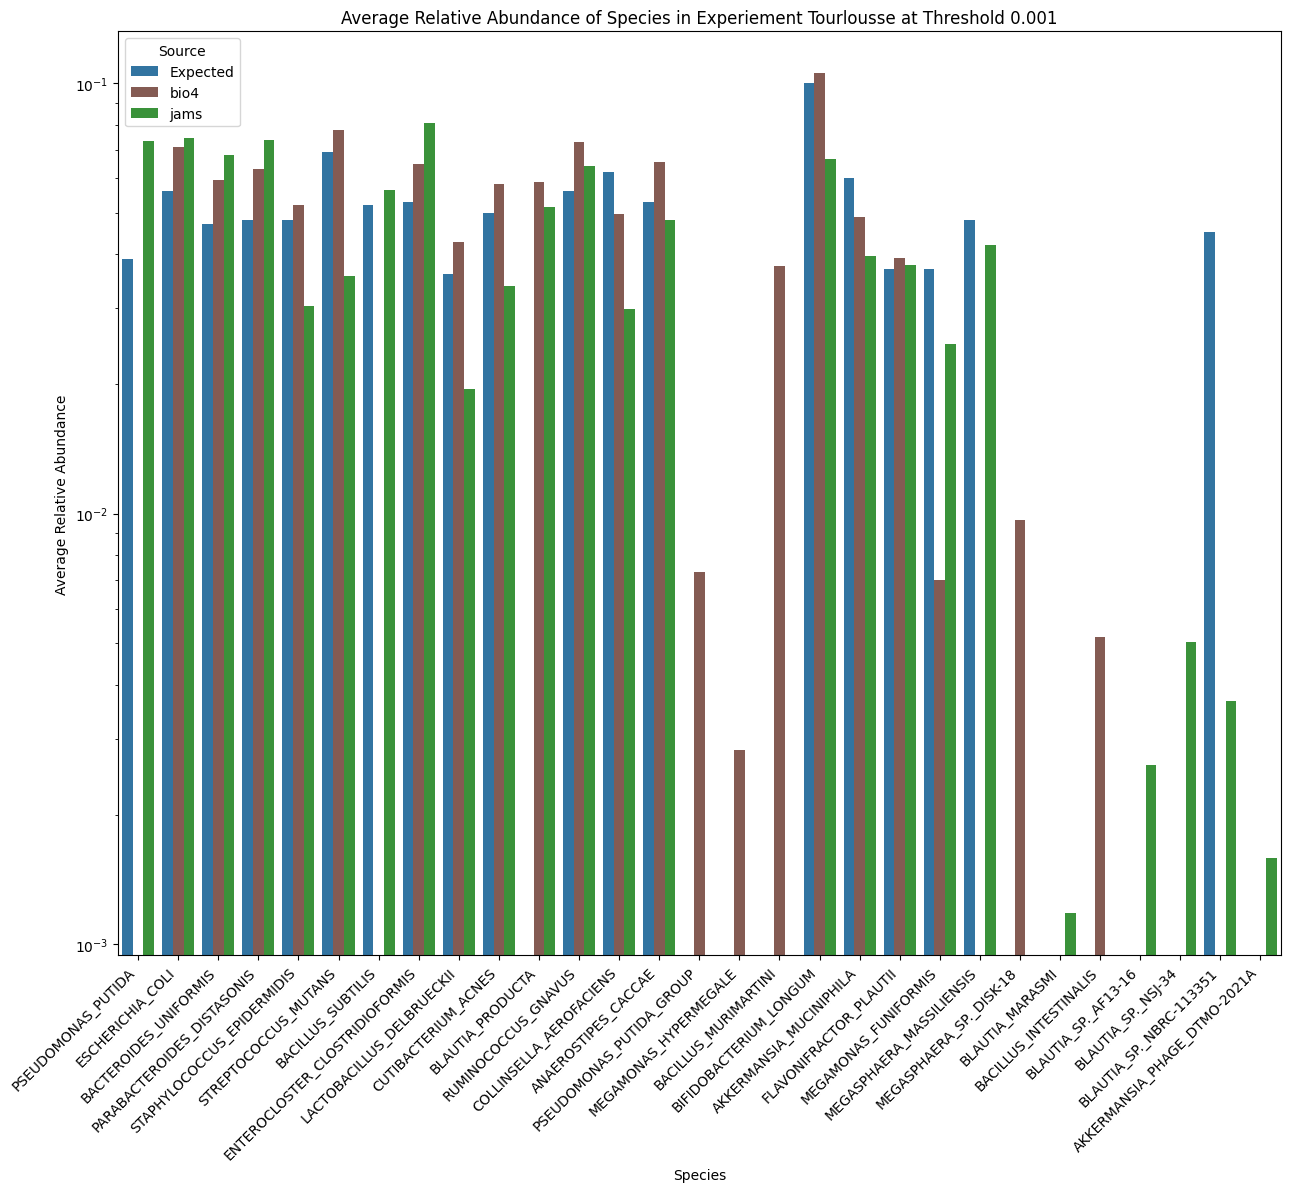

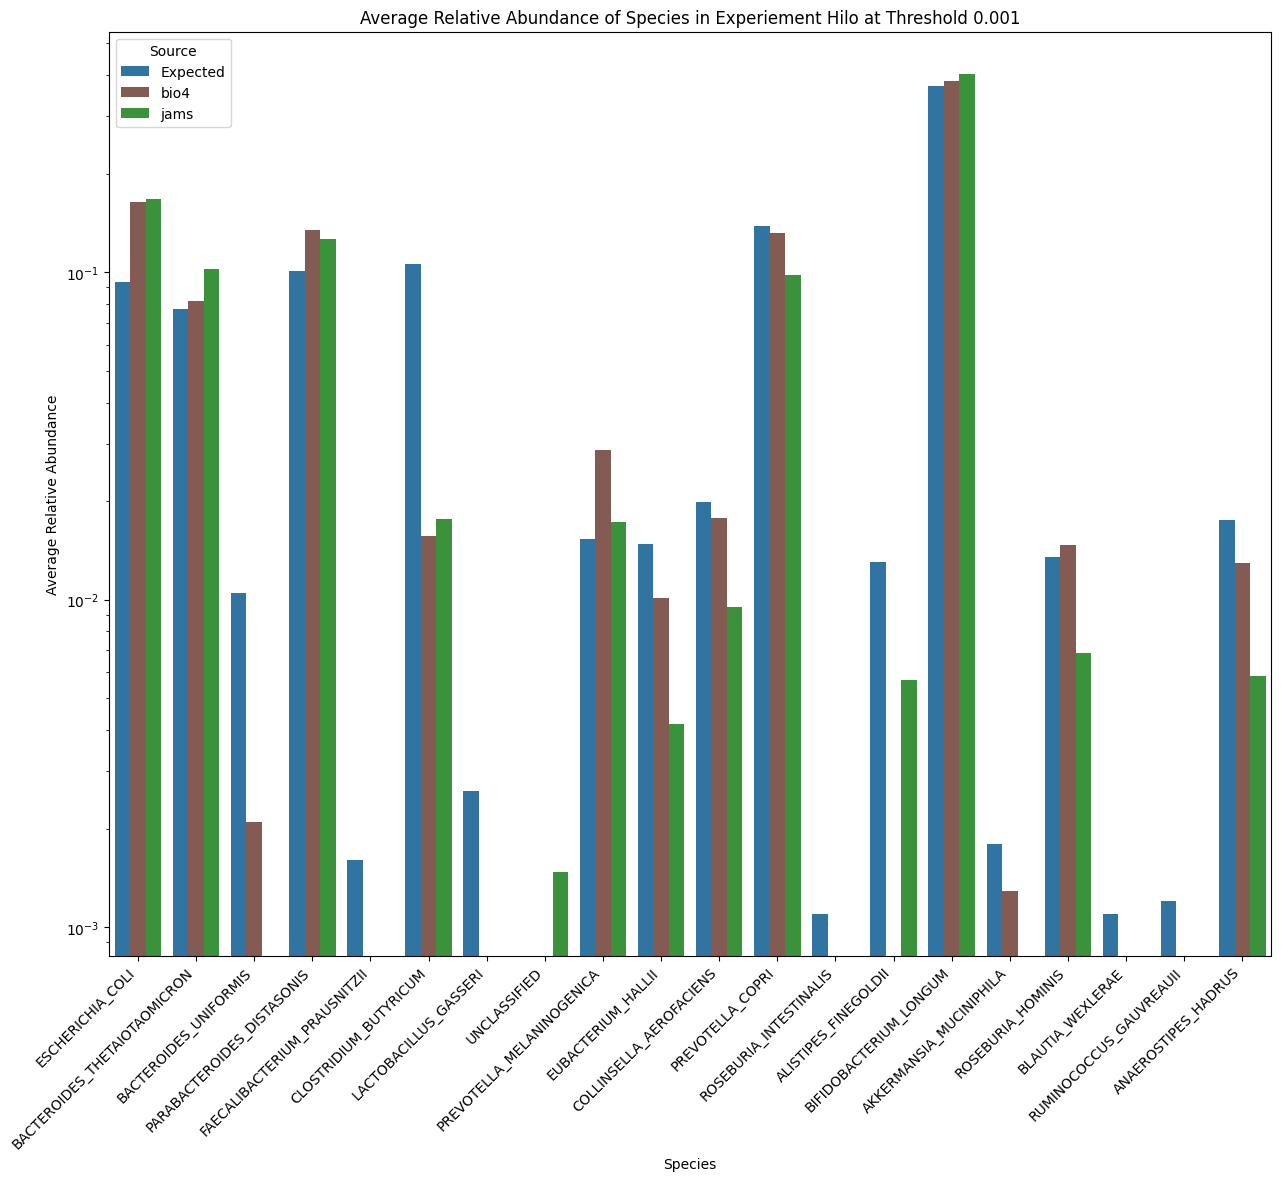

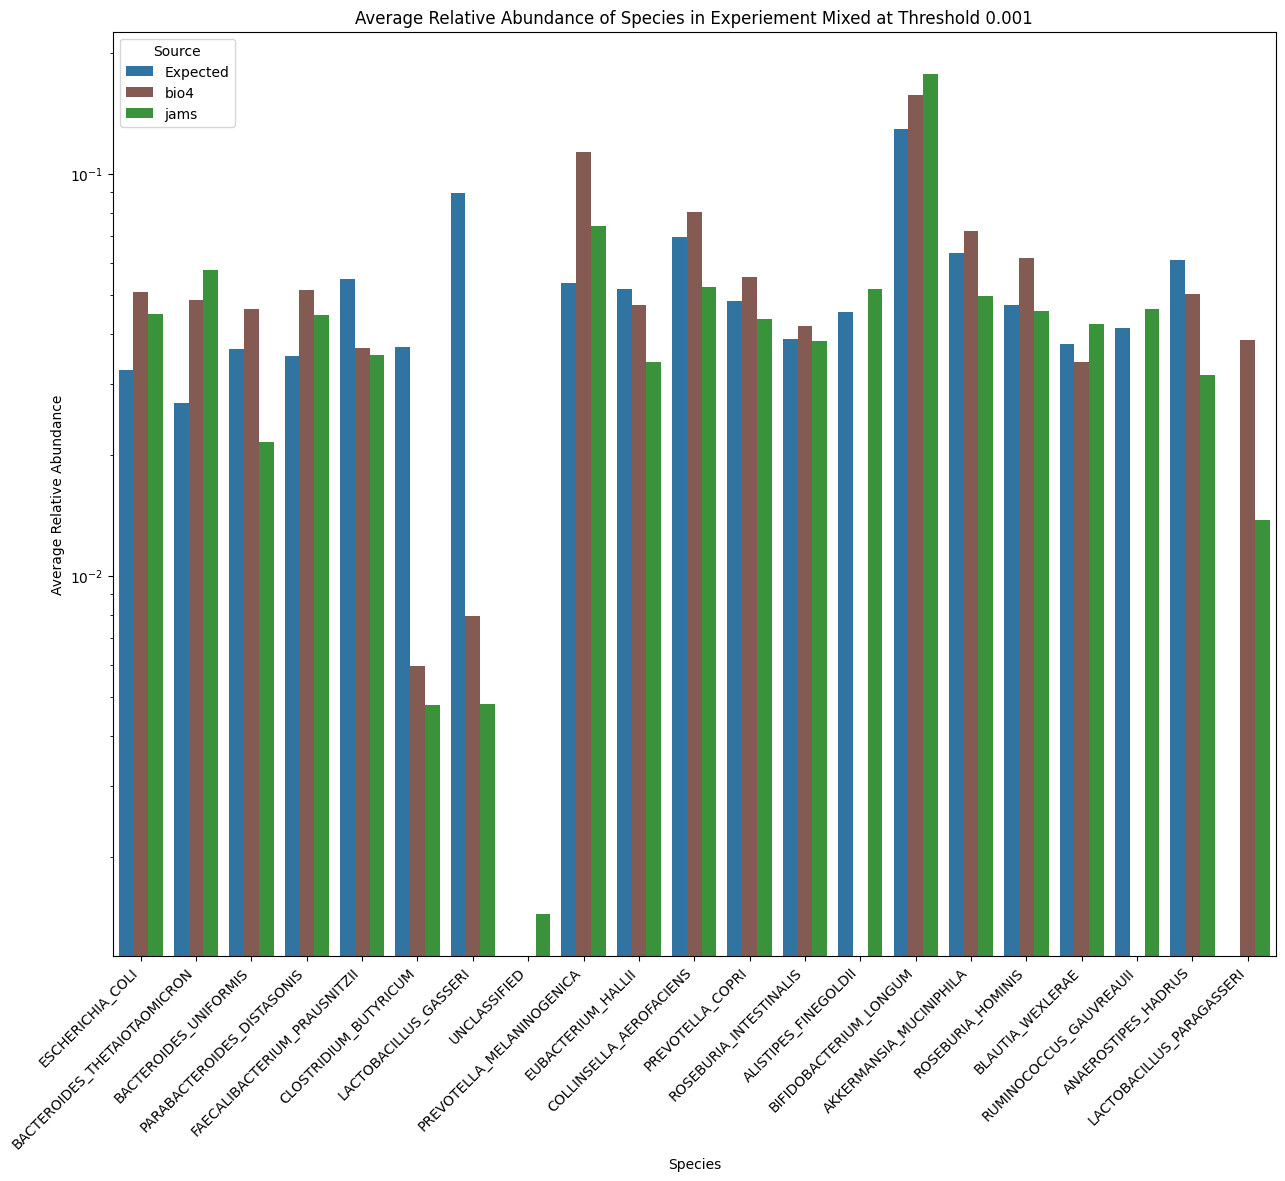

In [52]:
cb_palette = generate_cb()

def make_title(rank: str, exp_name: str, thresh: float):
    return f"Average Relative Abundance of {rank.capitalize()} in Experiement {exp_name.capitalize()} at Threshold {thresh}"

def plot_bars(thresh: float, rank: str = "genus"):
    for e in experiments:
        # Initialize the dataframe to hold the data.
        plt_df = pd.DataFrame()
        # Make the bigger figure.
        fig = plt.figure(figsize=(15, 12))

        exp_name = e.root.split("/")[-1]

        # Get the data for the experiment.
        fc = fully_combined(e.root, rank)
        fc.to_csv(f"{rank}_{exp_name}_fc.csv", index=True)
        for pl, pl_df in fc.groupby("Source"):
            # Average the abundances on the same index values. This keeps the names of the taxa.
            averaged_df = pl_df.groupby(["TAX_ID", rank, "Source"]).mean(numeric_only=True)

            # Filter out the values that are below the threshold.
            averaged_df = averaged_df.loc[averaged_df["RA"] > thresh]

            # Add the data to the plot dataframe.
            plt_df = pd.concat([plt_df, averaged_df], axis=0)

            # pl_df.to_csv(f"genus_{pl}.csv", index=True)

        plt_df.reset_index(inplace=True)        

        # We want only bio4 and jams.
        plt_df = plt_df.loc[plt_df["Source"].isin(["Expected", "bio4", "jams"])]

        # Plot the data.
        ax = sns.barplot(x="TAX_ID", y='RA', hue="Source", data=plt_df, errorbar=None, log=True, palette=cb_palette)
        ax.set_xticklabels(fix_x_labels(ax=ax, df=plt_df, rank=rank), rotation=45, horizontalalignment='right')

        # Make the title and add the axes labels.
        ax.set_title(make_title(rank, exp_name, thresh))
        ax.set_xlabel(rank.capitalize())
        ax.set_ylabel('Average Relative Abundance')

        # Save the plt_df.
        # plt_df.to_csv(f"{rank}_{exp_name}_{thresh}.csv", index=False)

plot_bars(0.001, "species")